# Nodule Segmentation: Model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configuration" data-toc-modified-id="Configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Find-mean-of-images" data-toc-modified-id="Find-mean-of-images-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Find mean of images</a></span></li><li><span><a href="#Find-variance-of-images" data-toc-modified-id="Find-variance-of-images-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Find variance of images</a></span></li></ul></li><li><span><a href="#Data-Iterator" data-toc-modified-id="Data-Iterator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Iterator</a></span></li><li><span><a href="#Evaluation-Metric" data-toc-modified-id="Evaluation-Metric-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation Metric</a></span></li><li><span><a href="#Model-Architecture" data-toc-modified-id="Model-Architecture-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Architecture</a></span></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimizer</a></span><ul class="toc-item"><li><span><a href="#Find--learning-rate" data-toc-modified-id="Find--learning-rate-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Find  learning rate</a></span></li><li><span><a href="#Optimizer-Parameters" data-toc-modified-id="Optimizer-Parameters-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Optimizer Parameters</a></span></li></ul></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train Model</a></span></li><li><span><a href="#Evaluate-Model" data-toc-modified-id="Evaluate-Model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Evaluate Model</a></span></li></ul></div>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0,"./src")

In [3]:
import mynnet7 as nn
import pickle
import mxnet as mx
from imports import *

## Configuration

In [4]:
interm_dir4='/home/mas/x110/Datasets/Dataset5/' 
s = "2018_10_31"
train_data_path=interm_dir4+'processed/train'+s+'.rec'
train_idx_path=interm_dir4+'processed/train'+s+'.idx'
valid_data_path=interm_dir4+'processed/valid'+s+'.rec'
valid_idx_path=interm_dir4+'processed/valid'+s+'.idx'
test_data_path=interm_dir4+'processed/test'+s+'.rec'
test_idx_path=interm_dir4+'processed/test'+s+'.idx'

In [5]:
find_stats = True
bs = 34
load_model = False
model_path = "/home/mas/x110/model/oct22"
model_epoch=499
prefix = "/home/mas/x110/model/oct31"

In [6]:
epochs = 500

## Preprocessing

### Find mean of images

In [7]:
if find_stats:
    BATCH_SIZE=1
    train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image=1)
    train_iter.reset()
    x_mean = np.zeros((32,32,32))
    for i,batch in enumerate(train_iter):
        X =  batch.data[0][0][0].asnumpy()
        x_mean+=X
    x_mean=np.mean(x_mean/i)
    # Saving the objects:
    with open(interm_dir4+'processed/x_mean.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([x_mean], f)

else:
    with open(interm_dir4+'processed/x_mean.pkl','rb') as f:  # Python 3: open(..., 'rb')
        x_mean = pickle.load(f)
x_mean#x_mean=.2815

0.27012206321241655

In [8]:
x_mean=0.27

### Find variance of images

In [9]:
if find_stats: 
    BATCH_SIZE=1
    train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image = 1)
    train_iter.reset()
    x_var = np.zeros((32,32,32))
    for i,batch in enumerate(train_iter):
        X =  (batch.data[0][0][0].asnumpy()-x_mean)**2
        x_var+=X
    #x_var=x_var/(i-1)
    #x_var#x_mean=.2815
    N = i*32*32*32
    x_var = np.sum(x_var)/(N-1)
    x_var#x_var = .07877
    x_std = np.sqrt(x_var)#x_std=.2807
    with open(interm_dir4+'processed/x_std.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([x_std], f)
else:
    with open(interm_dir4+'processed/x_std.pkl','rb') as f:  # Python 3: open(..., 'rb')
        x_std = pickle.load(f)
x_std#x_std=.2807

0.268007871005759

In [10]:
x_std = 0.27

## Data Iterator

In [11]:
BATCH_SIZE=bs
train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=False,mean_image=x_mean,std_image = x_std)
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print(input_shapes)

{'data': (34, 1, 32, 32, 32), 'softmax_label': (34, 32768)}


In [12]:
print(input_shapes)

{'data': (34, 1, 32, 32, 32), 'softmax_label': (34, 32768)}


In [13]:
BATCH_SIZE=bs
valid_iter=nn.FileIter(valid_data_path,valid_idx_path,batch_size=BATCH_SIZE,do_augment=False,mean_image=x_mean,std_image = x_std)

In [14]:
train_iter.reset()
valid_iter.reset()

## Evaluation Metric

In [15]:
def dice_coef2(label, y):
    smooth = 1.
    label=mx.nd.array(label).as_in_context(mx.gpu(0))
    y=mx.nd.array(y).as_in_context(mx.gpu(0))
    intersection = mx.nd.sum(label*y)
    return ((2. * intersection + smooth) / (mx.nd.sum(label) +mx.nd.sum(mx.nd.abs(y)) + smooth))


In [16]:
# ===============Evaluation metric(s)================= 
metric = mx.metric.CustomMetric(feval=nn.dice_coef2)

## Model Architecture

In [17]:
load_model

False

In [18]:
if load_model:
    network, arg_params, aux_params = mx.model.load_checkpoint(model_path , model_epoch)

    # Binding
    exe = network.simple_bind(ctx=mx.gpu(0), **input_shapes)


    exe.copy_params_from(arg_params, aux_params)
    
    # get handle to input arrays
    arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
    data = arg_arrays[train_iter.provide_data[0][0]]
    label = arg_arrays[train_iter.provide_label[0][0]]
else:

    network = nn.get_net_317()
    init = mx.init.Normal(0.01) #note biases and gamma/beta are not affected

    # Binding
    exe = network.simple_bind(ctx=mx.gpu(), **input_shapes)
    # get handle to input arrays
    arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
    data = arg_arrays[train_iter.provide_data[0][0]]
    label = arg_arrays[train_iter.provide_label[0][0]]
    for name, arr in arg_arrays.items():
        if name not in input_shapes:
            init(name, arr)


/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/ipykernel_launcher.py:27: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.


## Optimizer

### Find  learning rate

In [19]:
nb=train_iter.num_data//train_iter.batch_size

In [20]:
sched=nn.lr_find(1e-4,nb,end_lr=1)

In [21]:
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=.01,
    momentum=0.9,
    wd=0.00001,
    lr_scheduler=sched)

updater = mx.optimizer.get_updater(opt)

In [22]:
for epoch in range(0,1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    
    sched.reset()
        
    sched.on_train_begin()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
        e=metric.get()
        err_train=-e[1].asnumpy()[0]
        sched.on_batch_end(err_train)
    
    if epoch % 100== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 139.71043348312378 Epoch: 0 trainloss: -0.18696861 validloss: -0.18071817


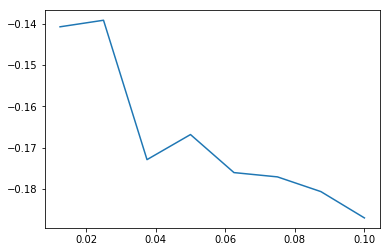

In [23]:
plt.plot(sched.lrs, sched.losses)

### Optimizer Parameters

In [24]:
# We also need to create an optimizer for updating weights
# ===============Optimizer=================                        
opt = mx.optimizer.SGD(
    learning_rate=.01,momentum=0.99,wd=0.000001)

In [25]:
updater.optimizer.lr_scheduler=None

In [26]:
updater = mx.optimizer.get_updater(opt)

## Train Model

In [27]:
Es_train=[]
for epoch in range(0,epochs+1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        Es_train.append(outputs[1].asnumpy()[0])
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
    e=metric.get()
    err_train=-e[1].asnumpy()[0]
    
    if epoch % 100== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 99.13337731361389 Epoch: 0 trainloss: -0.21006662 validloss: -0.22243527
time: 98.13234972953796 Epoch: 1 trainloss: -0.21784371 validloss: -0.2329826
time: 98.28647017478943 Epoch: 2 trainloss: -0.22565451 validloss: -0.24015585
time: 98.30458879470825 Epoch: 3 trainloss: -0.23762484 validloss: -0.26260078
time: 98.54022288322449 Epoch: 4 trainloss: -0.2469695 validloss: -0.2995131
time: 98.27189826965332 Epoch: 5 trainloss: -0.25938457 validloss: -0.28533262
time: 98.3297986984253 Epoch: 6 trainloss: -0.2757792 validloss: -0.30065966
time: 98.16549921035767 Epoch: 7 trainloss: -0.29839376 validloss: -0.3418324
time: 98.27327394485474 Epoch: 8 trainloss: -0.32213333 validloss: -0.26442698
time: 98.25467419624329 Epoch: 9 trainloss: -0.35070053 validloss: -0.26968226
time: 98.2281584739685 Epoch: 10 trainloss: -0.36434758 validloss: -0.41894838
time: 98.25940012931824 Epoch: 11 trainloss: -0.41212115 validloss: -0.41288796
time: 100.67501735687256 Epoch: 12 trainloss: -0.44332725

time: 100.03697514533997 Epoch: 104 trainloss: -0.86142844 validloss: -0.8189102
time: 111.5131688117981 Epoch: 105 trainloss: -0.87197465 validloss: -0.81019485
time: 102.14282488822937 Epoch: 106 trainloss: -0.8714419 validloss: -0.785817
time: 107.58115720748901 Epoch: 107 trainloss: -0.85275906 validloss: -0.6779071
time: 110.5771872997284 Epoch: 108 trainloss: -0.85043967 validloss: -0.7449916
time: 108.27163982391357 Epoch: 109 trainloss: -0.8662728 validloss: -0.7930954
time: 125.20734596252441 Epoch: 110 trainloss: -0.8633196 validloss: -0.82657224
time: 125.38067531585693 Epoch: 111 trainloss: -0.87527233 validloss: -0.8255826
time: 126.43857717514038 Epoch: 112 trainloss: -0.85854983 validloss: -0.8267223
time: 101.52550458908081 Epoch: 113 trainloss: -0.8525556 validloss: -0.79445165
time: 116.09350967407227 Epoch: 114 trainloss: -0.8528991 validloss: -0.7426984
time: 141.10627675056458 Epoch: 115 trainloss: -0.87358564 validloss: -0.7812447
time: 134.84520030021667 Epoch: 1

time: 125.2642023563385 Epoch: 206 trainloss: -0.9142902 validloss: -0.85737926
time: 125.2261745929718 Epoch: 207 trainloss: -0.89594054 validloss: -0.8504585
time: 131.04328155517578 Epoch: 208 trainloss: -0.92365485 validloss: -0.8342425
time: 134.79119277000427 Epoch: 209 trainloss: -0.9185366 validloss: -0.84746
time: 130.9949655532837 Epoch: 210 trainloss: -0.923588 validloss: -0.85706466
time: 138.69810390472412 Epoch: 211 trainloss: -0.9128103 validloss: -0.84623253
time: 138.85643005371094 Epoch: 212 trainloss: -0.9265204 validloss: -0.859681
time: 136.35539650917053 Epoch: 213 trainloss: -0.9224039 validloss: -0.8664108
time: 138.59972047805786 Epoch: 214 trainloss: -0.9226113 validloss: -0.8545657
time: 131.91803693771362 Epoch: 215 trainloss: -0.9206498 validloss: -0.8476559
time: 135.93557858467102 Epoch: 216 trainloss: -0.92353743 validloss: -0.83761364
time: 131.63702130317688 Epoch: 217 trainloss: -0.91727406 validloss: -0.852518
time: 127.35333561897278 Epoch: 218 trai

time: 132.89599347114563 Epoch: 308 trainloss: -0.95323795 validloss: -0.86507624
time: 132.4319896697998 Epoch: 309 trainloss: -0.9451836 validloss: -0.87597287
time: 132.5144500732422 Epoch: 310 trainloss: -0.95260394 validloss: -0.8751674
time: 102.46601223945618 Epoch: 311 trainloss: -0.938946 validloss: -0.85783774
time: 97.8660159111023 Epoch: 312 trainloss: -0.94653267 validloss: -0.8659707
time: 98.08803176879883 Epoch: 313 trainloss: -0.9556851 validloss: -0.8752208
time: 98.05097699165344 Epoch: 314 trainloss: -0.94721603 validloss: -0.88424623
time: 98.08797335624695 Epoch: 315 trainloss: -0.9483086 validloss: -0.86599785
time: 97.92254638671875 Epoch: 316 trainloss: -0.95057356 validloss: -0.8722948
time: 98.12565660476685 Epoch: 317 trainloss: -0.9556811 validloss: -0.87754196
time: 98.12435722351074 Epoch: 318 trainloss: -0.9549952 validloss: -0.8736828
time: 97.89565920829773 Epoch: 319 trainloss: -0.95301247 validloss: -0.88487107
time: 97.97349858283997 Epoch: 320 trai

time: 98.21736311912537 Epoch: 411 trainloss: -0.9761472 validloss: -0.8700983
time: 98.34607982635498 Epoch: 412 trainloss: -0.97623277 validloss: -0.89815503
time: 98.35931515693665 Epoch: 413 trainloss: -0.97029537 validloss: -0.89780986
time: 98.37481713294983 Epoch: 414 trainloss: -0.9772424 validloss: -0.8905025
time: 98.34135246276855 Epoch: 415 trainloss: -0.97546995 validloss: -0.8798534
time: 98.3924469947815 Epoch: 416 trainloss: -0.9785279 validloss: -0.8798948
time: 98.18431115150452 Epoch: 417 trainloss: -0.9764185 validloss: -0.8917431
time: 98.38339948654175 Epoch: 418 trainloss: -0.97782487 validloss: -0.8862625
time: 98.40623068809509 Epoch: 419 trainloss: -0.9785322 validloss: -0.8914248
time: 98.351637840271 Epoch: 420 trainloss: -0.97537595 validloss: -0.9002274
time: 98.3689775466919 Epoch: 421 trainloss: -0.97838604 validloss: -0.88567096
time: 98.24748182296753 Epoch: 422 trainloss: -0.9779405 validloss: -0.8920606
time: 98.39670753479004 Epoch: 423 trainloss: -

In [28]:
np.mean(Es_train2,axis=1)

NameError: name 'Es_train2' is not defined

In [ ]:
Es_train[-5:]

In [ ]:
Es_train = np.array(Es_train)

In [ ]:
Es_train

In [ ]:
Es_train2 = Es_train.reshape((-1,2))

In [ ]:
np.mean(Es_train2,axis=1)

In [ ]:
train_iter.num_data

In [ ]:
bs

In [ ]:
68/34

In [ ]:
plt.plot(Es_train,'.-')

## Evaluate Model

In [ ]:
BATCH_SIZE=1
test_iter=nn.FileIter(test_data_path,test_idx_path,batch_size=BATCH_SIZE,do_shuffle=False,mean_image=x_mean,std_image = x_std)

In [ ]:
def get_sample_at(valid_iter,n):
    valid_iter.ind2=[n]
    return valid_iter.next()

In [ ]:
K = valid_iter.num_data
n = random.randint(0,K)
print('index = '+ str(n))
batch = get_sample_at(valid_iter,n)


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.7, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none',  alpha=0.4, vmin=0, vmax=1)


      
plt.tight_layout()